In [ ]:
from dataclasses import dataclass
from enum import StrEnum
from datetime import datetime, timedelta, date
import polars as pl
from collections import defaultdict, Counter
from typing import Tuple
from common.constants.column_types import (
    CPZP_SCHEMA,
    OZP_SCHEMA,
    POHLAVI_CPZP,
    TYP_UDALOSTI,
)
from common.constants.column_names import SHARED_COLUMNS, OZP_COLUMNS, CPZP_COLUMNS
import pickle
from common.constants.objects import (
    Person,
    Gender,
    AgeCohort,
    Prescription,
    PrescriptionType,
)
import matplotlib.pyplot as plt
import numpy as np
import os
from common.utils import (
    draw_chart,
    filter_by_date_range,
)

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(60)

from typing import Any
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from scipy.stats import fisher_exact

pl.Config.set_tbl_rows(-1)
import statistics

POJISTOVNA = "cpzp"
VAX_PERIOD_IN_DAYS = 30
START_DATE = date(2015, 1, 1)
END_DATE = date(2025, 1, 1)
PERIOD = 365


def is_injection(form: str) -> bool:
    return form in {"Injekční suspenze", "Injekční/infuzní roztok"}


def skip_person_for_novax(p) -> bool:
    return (
        (p.zahajeni_pojisteni > START_DATE)
        or (p.ukonceni_pojisteni is not None and p.ukonceni_pojisteni < END_DATE)
        or p.died_at
        or bool(p.vaccines)
        or not p.prescriptions
    )


def skip_person_for_vax(p) -> bool:
    return (
        (p.zahajeni_pojisteni > START_DATE)
        or (p.ukonceni_pojisteni is not None and p.ukonceni_pojisteni < END_DATE)
        or p.died_at
        or (not p.vaccines)
        or (not p.prescriptions)
    )


def collapse_injections(prescriptions):
    """Yield prescriptions but ignore additional injections within 14 days."""
    last_inj_date = date.min
    for pr in prescriptions:
        if is_injection(pr.lekova_forma):
            if abs((last_inj_date - pr.date).days) < 14:
                continue
            last_inj_date = pr.date
        yield pr


def safe_div(a: float, b: float) -> float:
    return np.nan if b == 0 else a / b


def pvalue_from_df(df: pl.DataFrame) -> float:
    """Fisher exact test on Polars df with rows očkovaní/neočkovaní, cols před/po"""
    table = [
        [
            int(df.filter(pl.col("group") == "očkovaní")["před"][0]),
            int(df.filter(pl.col("group") == "očkovaní")["po"][0]),
        ],
        [
            int(df.filter(pl.col("group") == "neočkovaní")["před"][0]),
            int(df.filter(pl.col("group") == "neočkovaní")["po"][0]),
        ],
    ]
    return fisher_exact(table, alternative="two-sided")[1]


def before_after_df(
    vax_map: dict[int, float], novax_map: dict[int, float], pivot: int = 0
) -> pl.DataFrame:
    def sums(m):
        before = sum(v for d, v in m.items() if d < pivot)
        after = sum(v for d, v in m.items() if d >= pivot)
        return before, after

    vb, va = sums(vax_map)
    nb, na = sums(novax_map)
    return pl.DataFrame(
        {
            "group": ["očkovaní", "neočkovaní"],
            "před": [float(vb), float(nb)],
            "po": [float(va), float(na)],
        }
    )


from collections import Counter, defaultdict
from datetime import date
import pandas as pd
import numpy as np


def find_wave_start(
    dates: list[date],
    smooth_window: int = 7,
    consec_increase_days: int = 5,
    min_level_frac: float = 0.05,
) -> date | None:
    if not dates:
        return None

    counts = Counter(dates)
    idx = pd.date_range(min(counts), max(counts), freq="D")
    s = pd.Series([counts.get(d.date(), 0) for d in idx], index=idx)

    sm = s.rolling(smooth_window, min_periods=1).mean()
    diff_pos = sm.diff() > 0
    runs = diff_pos.groupby((~diff_pos).cumsum()).cumcount() + 1
    runs[~diff_pos] = 0

    min_level = max(1.0, sm.max() * min_level_frac)

    candidates = sm[(sm >= min_level) & (runs >= consec_increase_days)]
    if not candidates.empty:
        t = candidates.index[0]
        pre = sm.loc[:t].tail(smooth_window * 2)
        return pre.idxmin().date()

    # fallback – když nic nesplní podmínky
    first_pos = sm[sm.diff() > 0]
    if not first_pos.empty:
        return first_pos.index[0].date()

    # úplný fallback – prostě první den v datech
    return idx[0].date()

In [2]:
if POJISTOVNA == "both_companies":
    with open("./DATACON_data/cpzp_persons.pkl", "rb") as f:
        cpzp_persons: list[Person] = pickle.load(f)
    with open("./DATACON_data/ozp_persons.pkl", "rb") as f:
        ozp_persons: list[Person] = pickle.load(f)
    persons = cpzp_persons + ozp_persons
else:
    with open(f"./DATACON_data/{POJISTOVNA}_persons.pkl", "rb") as f:
        persons: list[Person] = pickle.load(f)

In [ ]:
vax_dates_map = defaultdict(lambda: defaultdict(list))
max_vax_intensity_map = defaultdict(dict)
start_vax_date_map = defaultdict(dict)

novax_ppl_predpisy_map = defaultdict(lambda: defaultdict(int))
novax_ppl_prvopredpisy_map = defaultdict(lambda: defaultdict(int))
novax_ppl_prednison_equivs_map = defaultdict(lambda: defaultdict(float))
novax_ppl_imunosupresivy_map = defaultdict(lambda: defaultdict(int))

vax_ppl_prvopredpisy_map = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
vax_ppl_predpisy_map = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
vax_ppl_prednison_equivs_map = defaultdict(
    lambda: defaultdict(lambda: defaultdict(int))
)
vax_ppl_imunosupresivy_map = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

# --- Max vaccination dates by cohort ----------------------------------------
for person in persons:
    if person.died_at or not person.vaccines:
        continue
    for v in person.vaccines:
        vax_dates_map[v.age_cohort][v.dose_number].append(v.date)

for cohort, doses in vax_dates_map.items():
    for dose, dates in doses.items():
        if not dates:
            continue

        # Spočítat denní počty
        counts = Counter(dates)
        sorted_counts = sorted(counts.items())  # [(date, count), ...]

        # Najít maximum (peak)
        max_day, max_count = max(counts.items(), key=lambda x: x[1])

        # Najít první den, kdy to překročilo třeba 5 % maxima
        threshold = max_count * 0.5
        start_day = next(day for day, cnt in sorted_counts if cnt >= threshold)

        start_vax_date_map[cohort][dose] = start_day
# --- NOVAX metrics -----------------------------------------------------------
for p in persons:
    if skip_person_for_novax(p):
        continue

    for pr in collapse_injections(p.prescriptions):
        cohort = pr.age_cohort_at_prescription
        if pr.prescription_type == PrescriptionType.IMUNOSUPRESSIVE:
            novax_ppl_imunosupresivy_map[cohort][pr.date] += 1

        novax_ppl_predpisy_map[cohort][pr.date] += 1
        novax_ppl_prednison_equivs_map[cohort][pr.date] += pr.prednison_equiv

    first = min(p.prescriptions, key=lambda x: x.date)
    novax_ppl_prvopredpisy_map[first.age_cohort_at_prescription][first.date] += 1


# --- VAX metrics -------------------------------------------------------------
for p in persons:
    if skip_person_for_vax(p):
        continue

    for v in p.vaccines:
        max_int_date = start_vax_date_map[v.age_cohort][v.dose_number]
        relative_date = (v.date - max_int_date).days
        if relative_date > 2 * VAX_PERIOD_IN_DAYS or relative_date < 0:
            continue

        # prescriptions relative to this vax
        for pr in collapse_injections(p.prescriptions):
            rel_day = (pr.date - v.date).days
            if pr.prescription_type == PrescriptionType.IMUNOSUPRESSIVE:
                vax_ppl_imunosupresivy_map[v.age_cohort][v.dose_number][rel_day] += 1

            vax_ppl_predpisy_map[v.age_cohort][v.dose_number][rel_day] += 1
            vax_ppl_prednison_equivs_map[v.age_cohort][v.dose_number][
                rel_day
            ] += pr.prednison_equiv

        first = min(p.prescriptions, key=lambda x: x.date)
        rel_first = (first.date - v.date).days
        vax_ppl_prvopredpisy_map[v.age_cohort][v.dose_number][rel_first] += 1

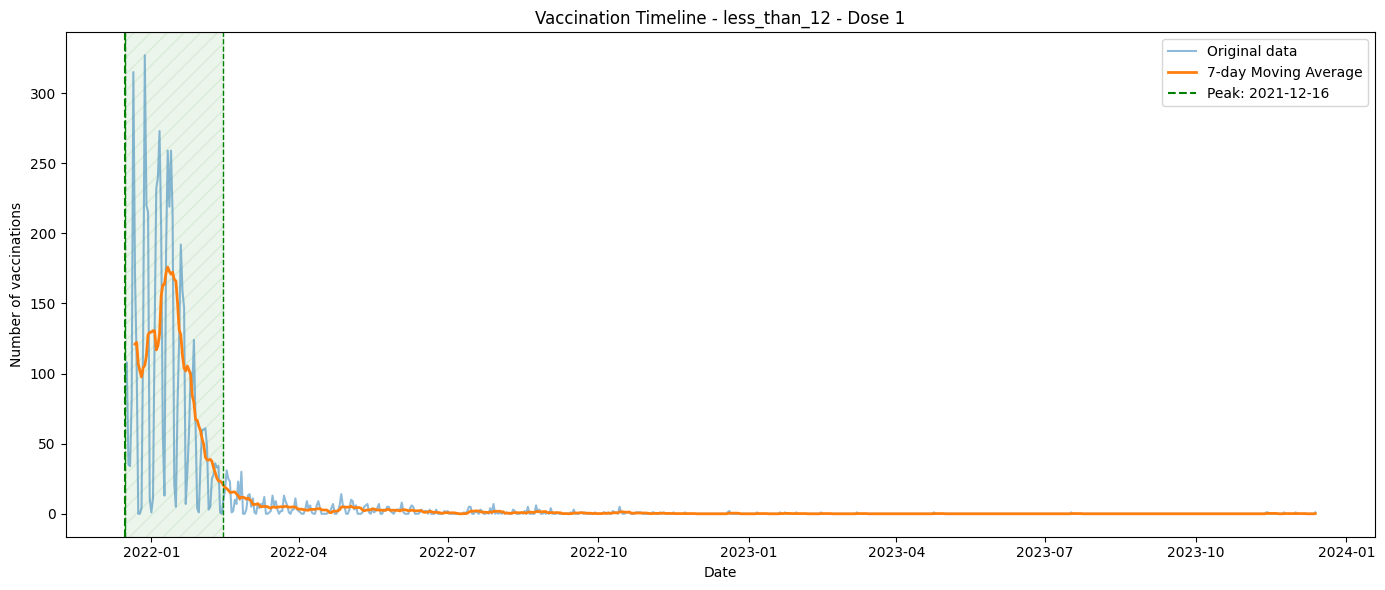

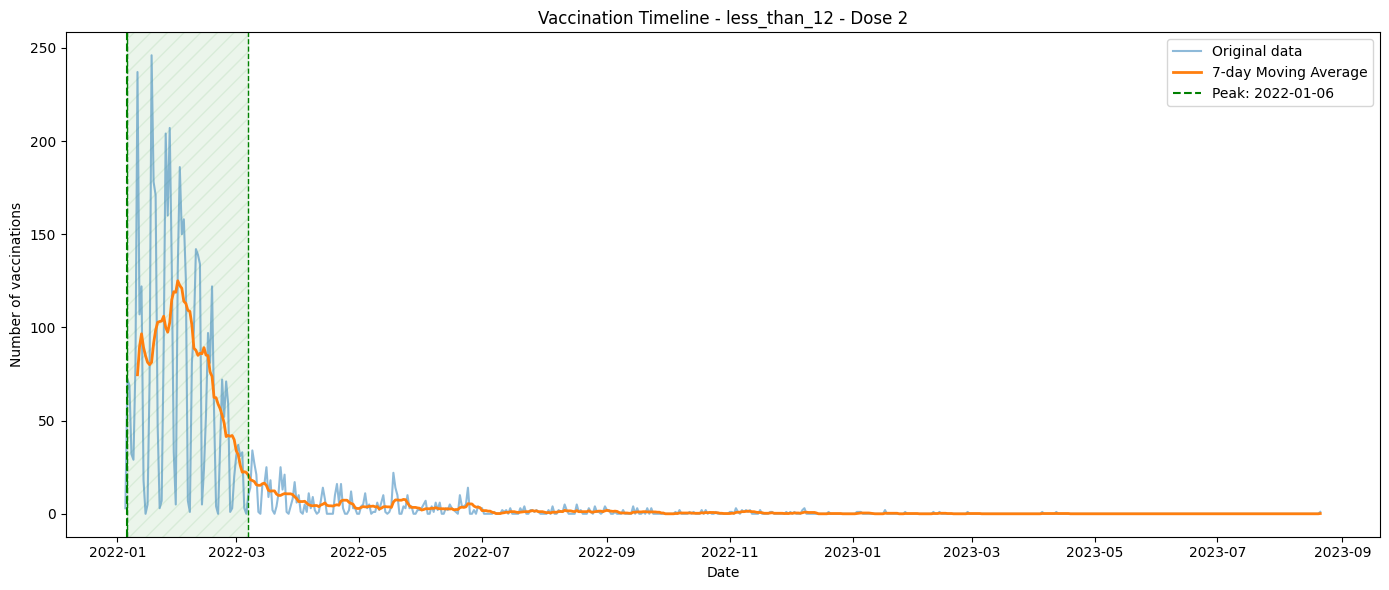

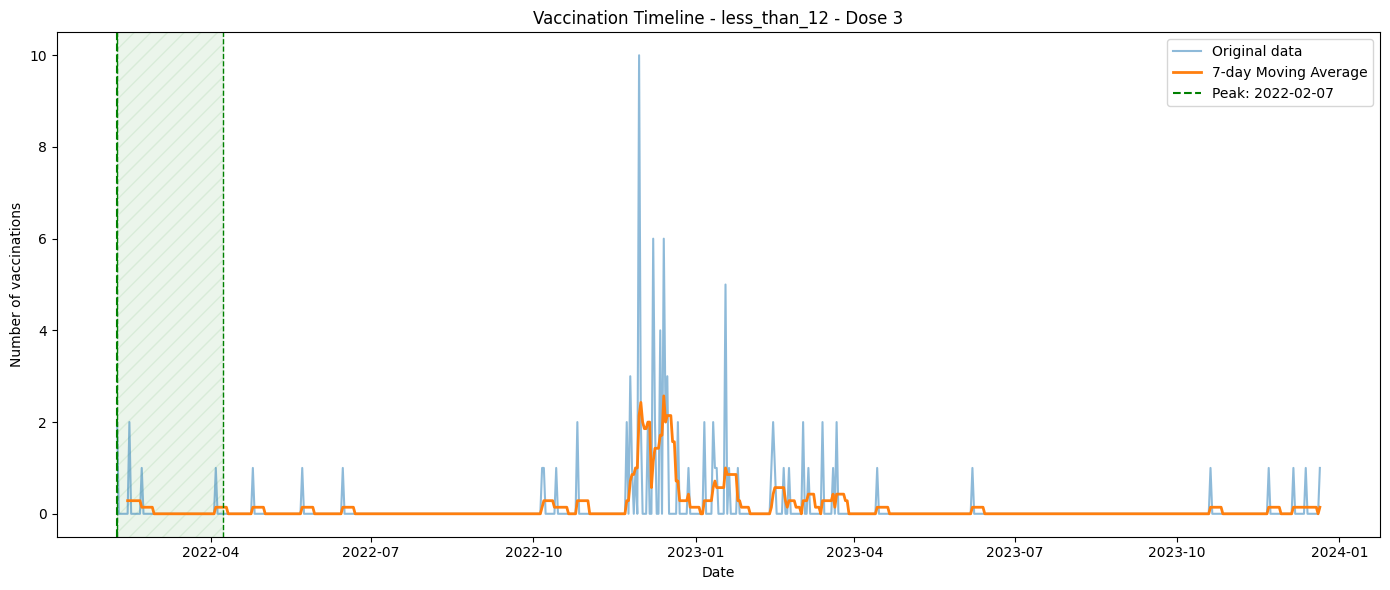

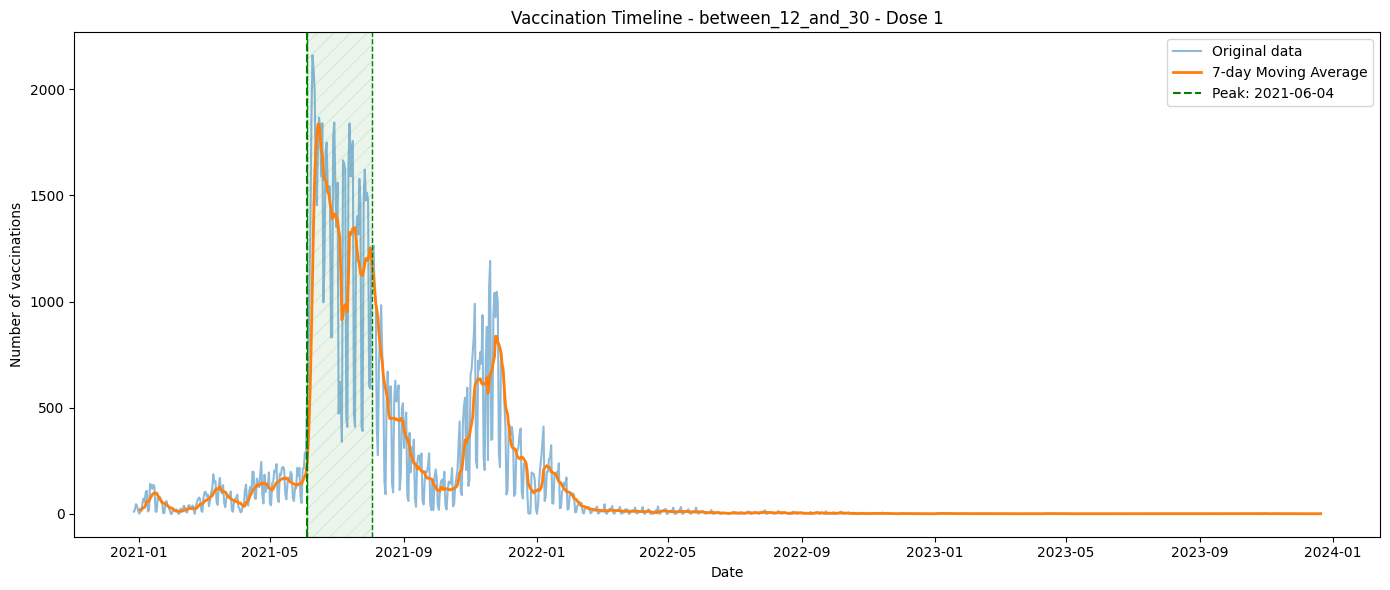

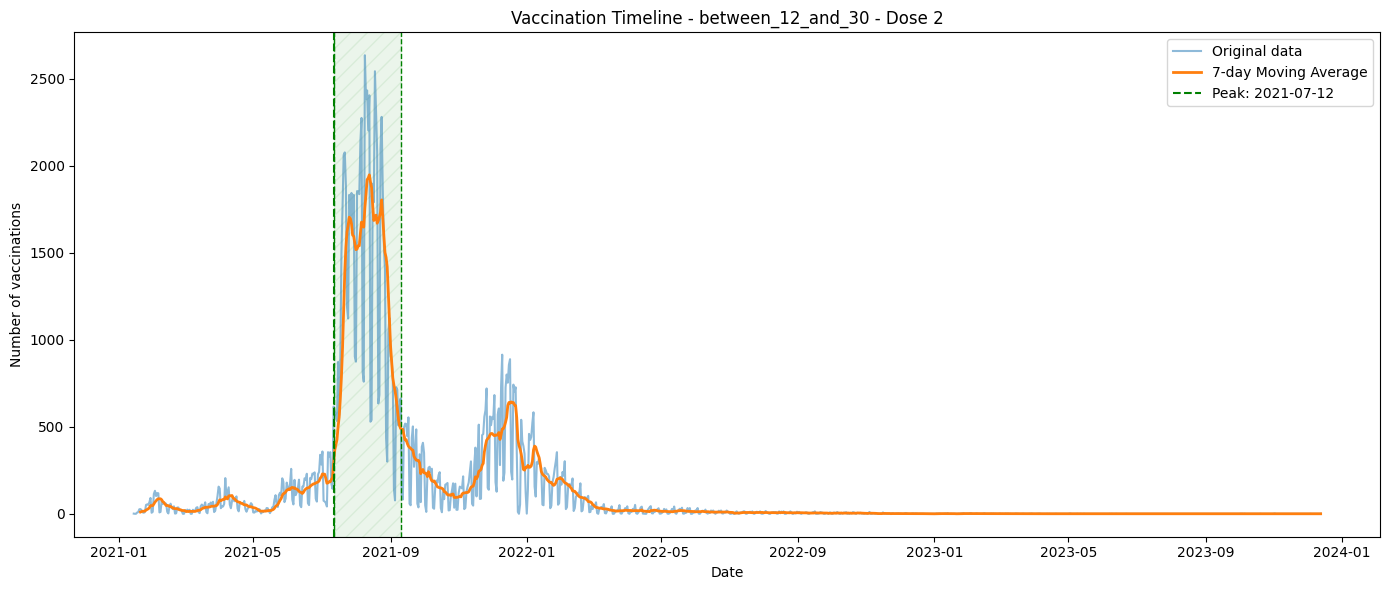

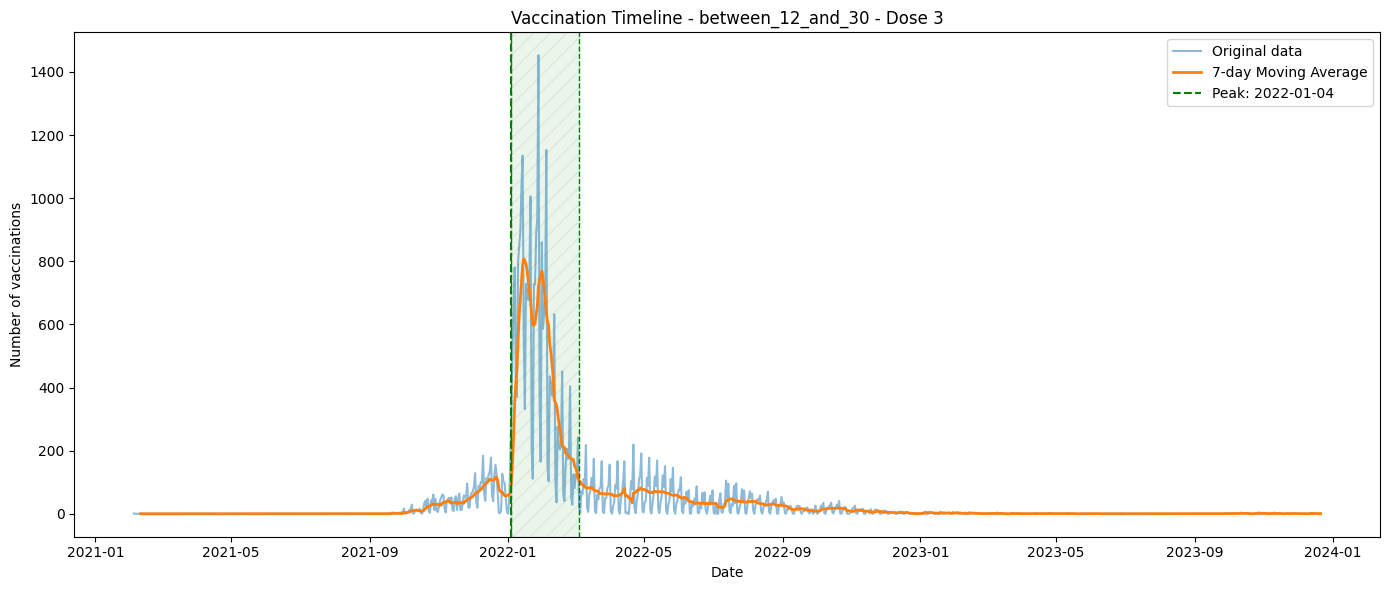

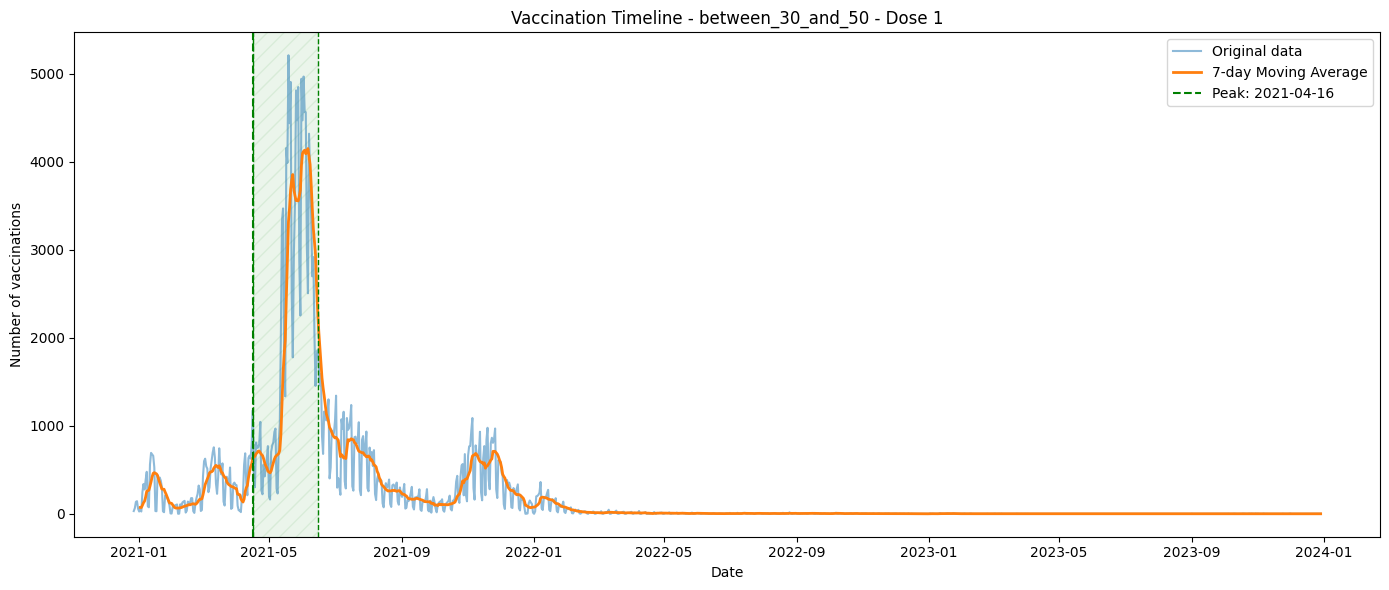

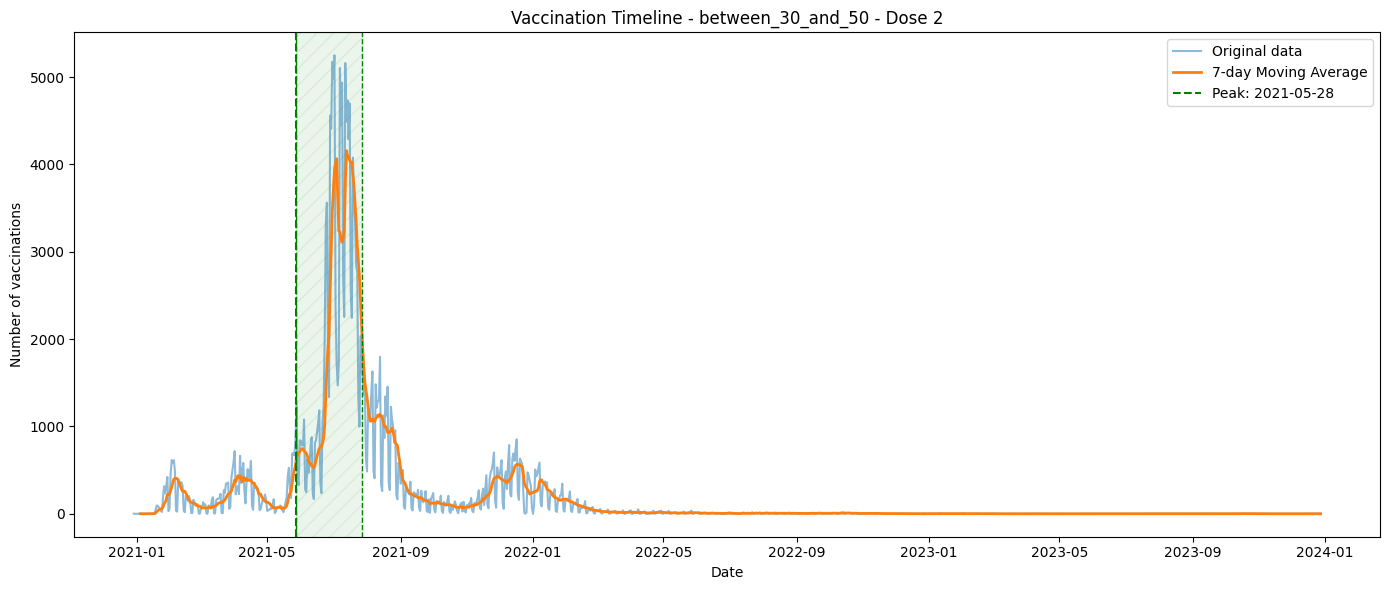

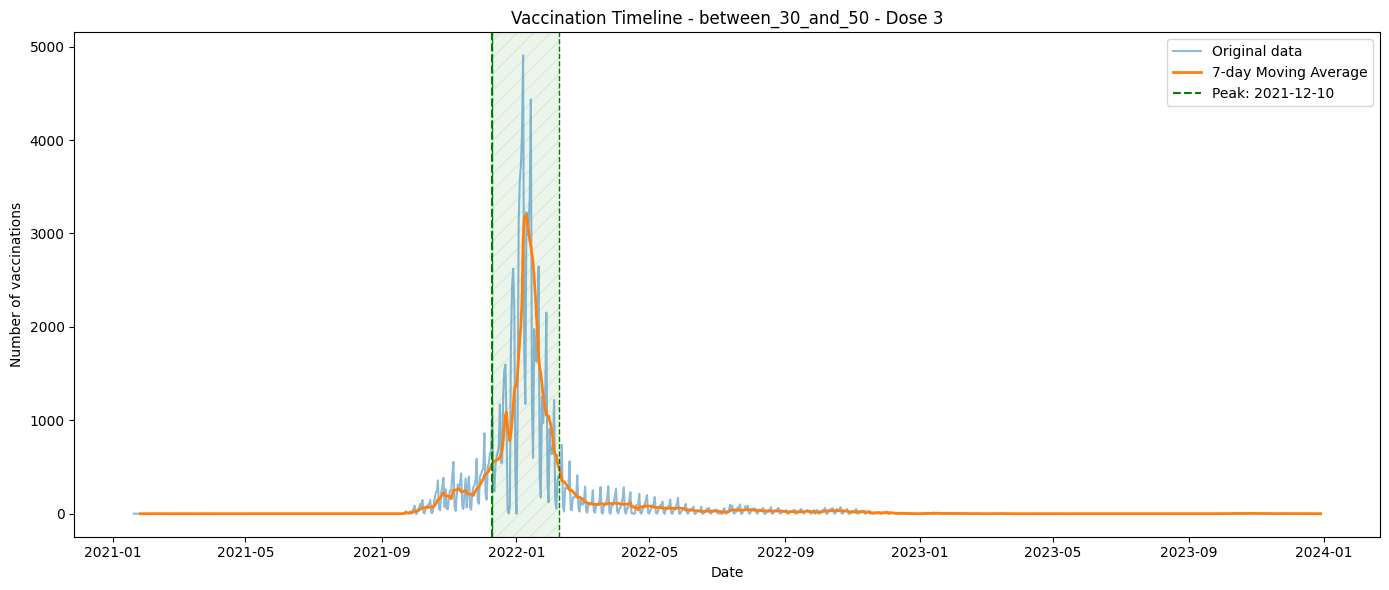

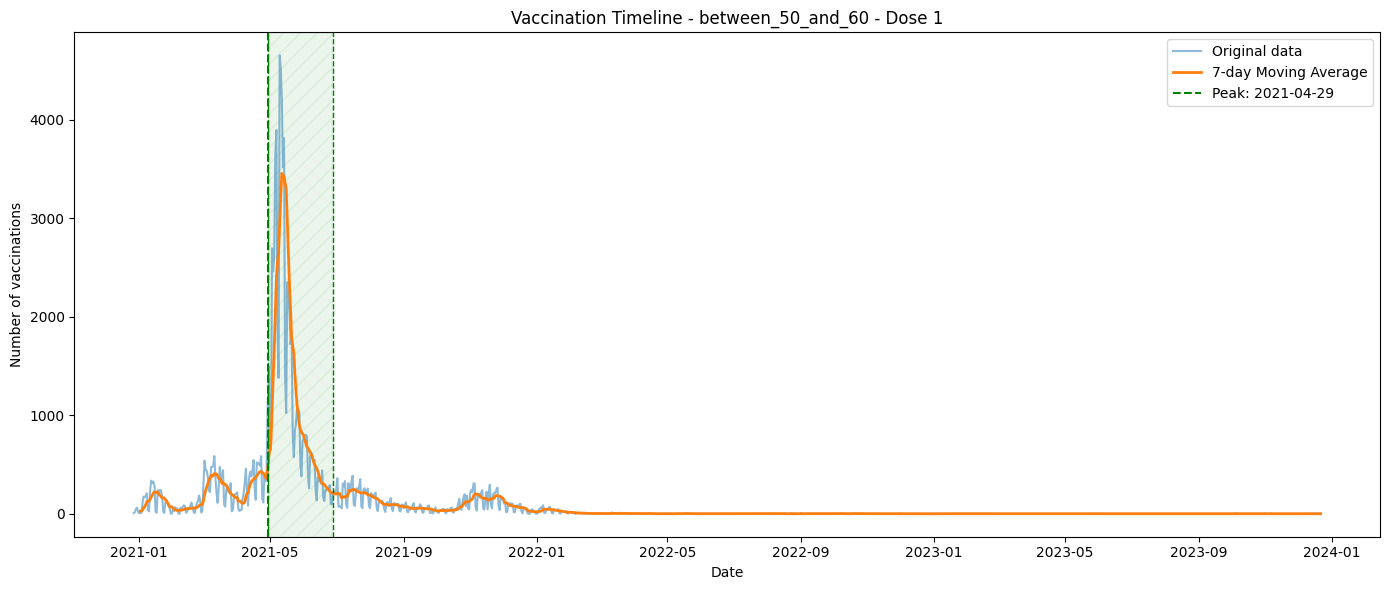

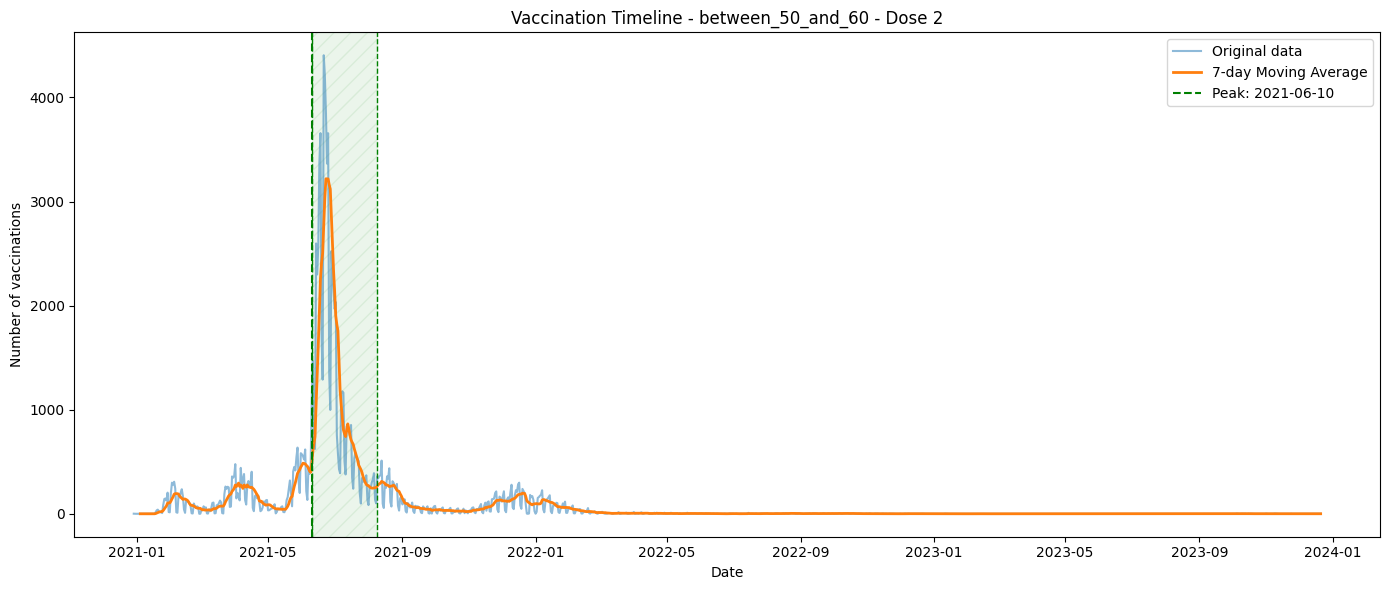

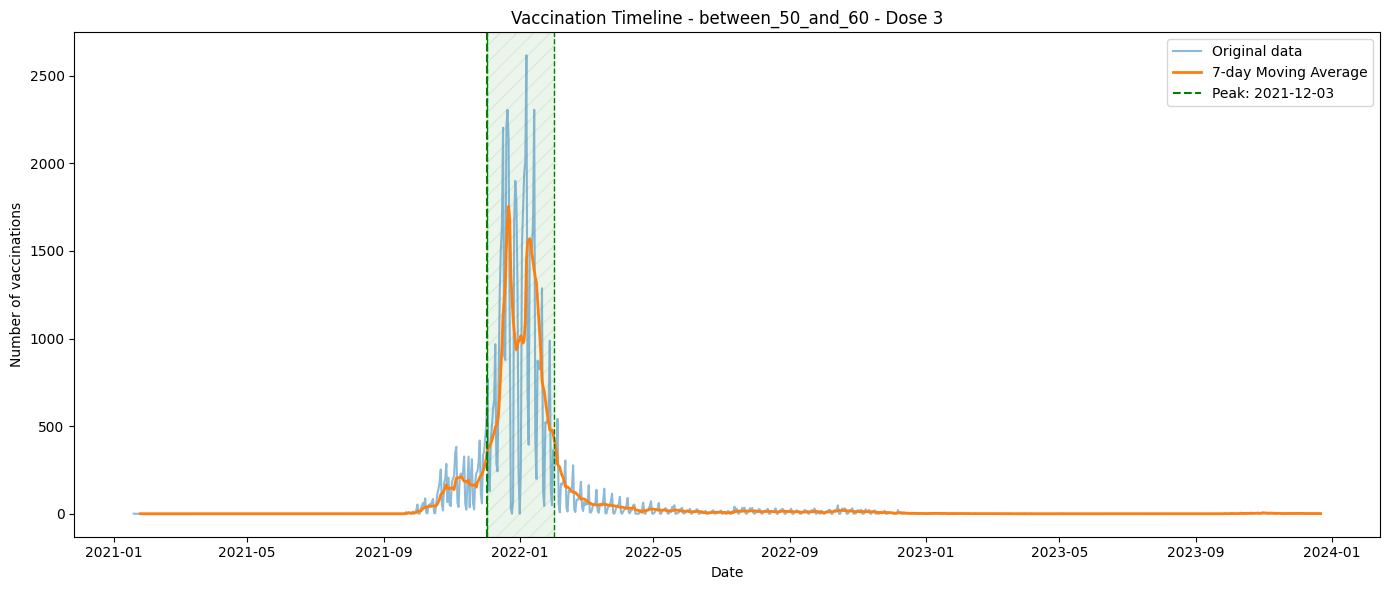

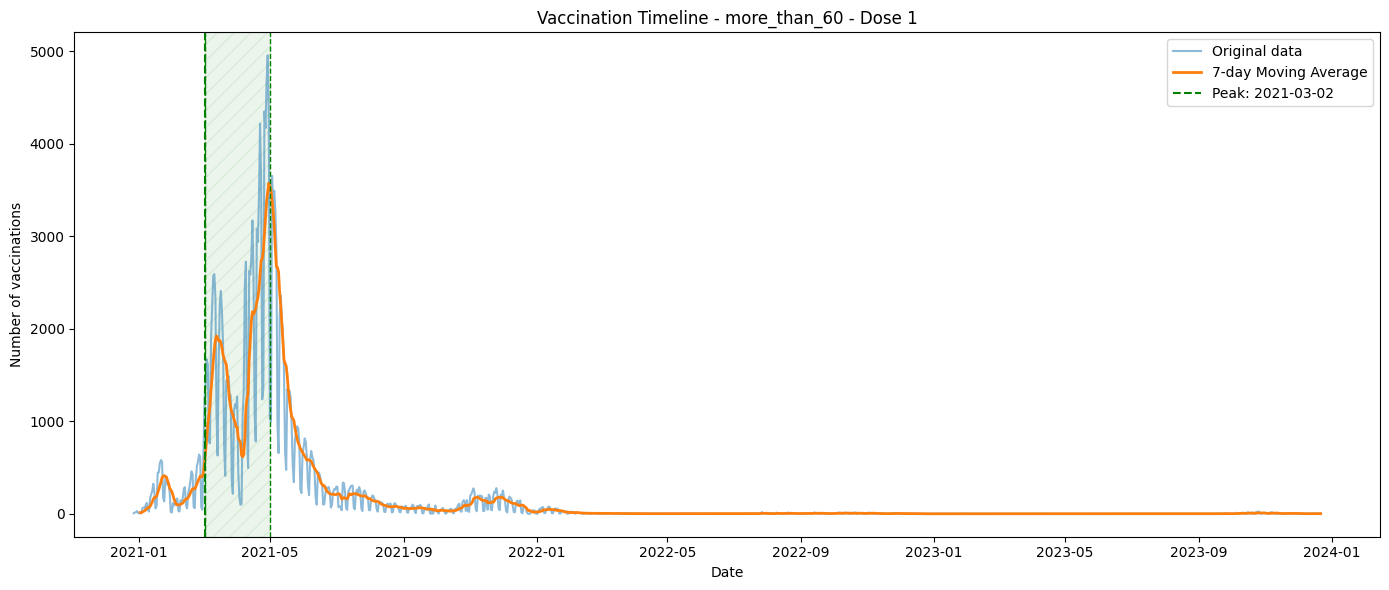

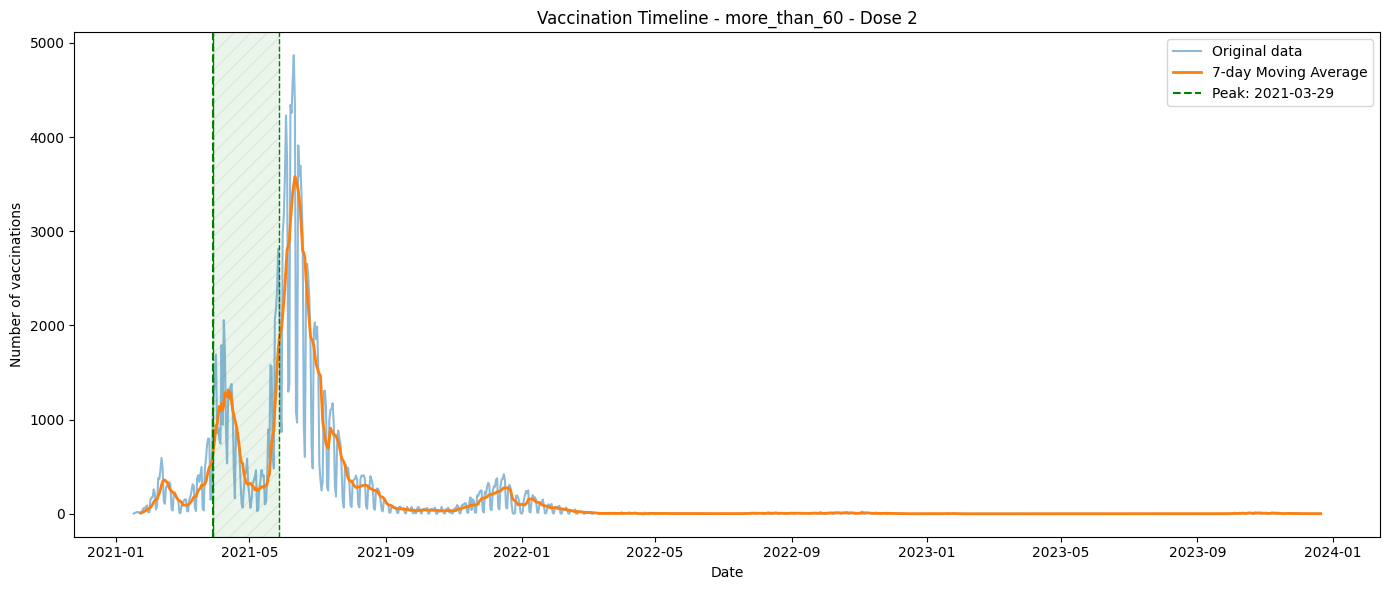

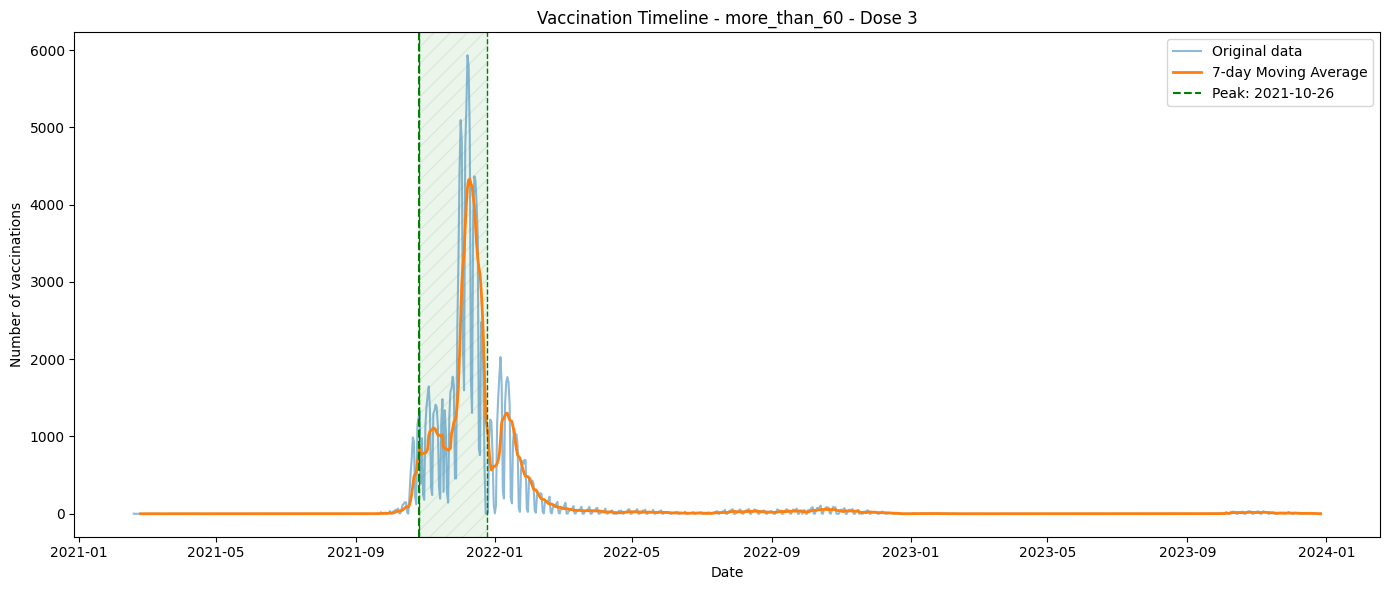

In [14]:
def plot_vax_timeline(vax_dates_map, max_vax, age_cohort, dose_number):
    df = pl.DataFrame({"date": vax_dates_map[age_cohort][dose_number]})
    counts = df.group_by("date").len().rename({"len": "count"}).sort("date")
    start, end = counts["date"].min(), counts["date"].max()
    counts = (
        pl.DataFrame({"date": pl.date_range(start, end, "1d", eager=True)})
        .join(counts, on="date", how="left")
        .fill_null(0)
        .with_columns(pl.col("count").rolling_mean(7).alias("ma"))
    )

    # peak den
    peak_date = max_vax[age_cohort][dose_number]

    # -30 a +30 dní
    left = peak_date
    right = peak_date + 2 * timedelta(days=30)

    plt.figure(figsize=(14, 6))
    plt.plot(counts["date"], counts["count"], label="Original data", alpha=0.5)
    plt.plot(counts["date"], counts["ma"], label="7-day Moving Average", linewidth=2)

    # peak + popisek
    plt.axvline(
        peak_date,
        color="green",
        linestyle="--",
        linewidth=1.5,
        label=f"Peak: {peak_date}",
    )

    # -30 / +30 dní a vyšrafovaná oblast
    plt.axvline(left, color="green", linestyle="--", linewidth=1)
    plt.axvline(right, color="green", linestyle="--", linewidth=1)
    plt.axvspan(
        left, right, facecolor="green", alpha=0.08, hatch="//", edgecolor="green"
    )

    plt.title(f"Vaccination Timeline - {age_cohort} - Dose {dose_number}")
    plt.xlabel("Date")  # klidně změním na denní offsety
    plt.ylabel("Number of vaccinations")
    plt.legend()
    plt.tight_layout()
    # os.makedirs(f"out/{POJISTOVNA}/vax_period", exist_ok=True)
    # plt.savefig(
    #     f"out/{POJISTOVNA}/vax_period/{age_cohort.value}-dose_{dose_number}.png"
    # )
    plt.show()
    plt.close()


for age_cohort in AgeCohort:
    for dose_number in [1, 2, 3]:
        plot_vax_timeline(vax_dates_map, start_vax_date_map, age_cohort, dose_number)

In [56]:
class ChartDrawer:
    def draw_2x2_block(
        self,
        vax_dates_map,
        novax_dates_map,
        rozhodne_datum,
        title,
        axes,
        row_offset,
        col_offset,
    ):
        vax_sums = self.__get_before_after_sums(vax_dates_map, rozhodne_datum)
        novax_sums = self.__get_before_after_sums(novax_dates_map, rozhodne_datum)
        total_vax_sum = sum(vax_sums.values())
        total_novax_sum = sum(novax_sums.values())

        # Očkovaná skupina
        self.__draw_scatter_plot(
            axes[row_offset][col_offset],
            list(vax_dates_map.keys()),
            list(vax_dates_map.values()),
            f"{title} - Očkovaná skupina",
            rozhodne_datum,
            total_vax_sum,
        )

        self.__draw_bar_chart(
            axes[row_offset][col_offset + 1],
            list(vax_sums.keys()),
            list(vax_sums.values()),
            f"{title} - Očkovaná skupina",
        )

        # Neočkovaná skupina
        self.__draw_scatter_plot(
            axes[row_offset + 1][col_offset],
            list(novax_dates_map.keys()),
            list(novax_dates_map.values()),
            f"{title} - Neočkovaná skupina",
            rozhodne_datum,
            total_novax_sum,
        )

        self.__draw_bar_chart(
            axes[row_offset + 1][col_offset + 1],
            list(novax_sums.keys()),
            list(novax_sums.values()),
            f"{title} - Neočkovaná skupina",
        )

    def __draw_scatter_plot(self, ax, x_data, y_data, title, rozhodne_datum, total_sum):
        ax.plot(x_data, y_data, label="Data", alpha=0.7, marker="o", linestyle="None")

        # --- Bucket by weeks (7-day bins) ---
        weekly_buckets = defaultdict(list)
        for x, y in zip(x_data, y_data):
            # integer division to assign week bin
            week_start = (x // 7) * 7
            weekly_buckets[week_start].append(y)

        # Compute weekly averages
        weekly_avg_points = sorted(
            (week_start, sum(vals) / len(vals))
            for week_start, vals in weekly_buckets.items()
        )
        avg_x, avg_y = zip(*weekly_avg_points)

        # --- Draw line for weekly averages ---
        ax.plot(avg_x, avg_y, linewidth=2, marker="o", label="Týdenní průměr")

        # rozhodné datum (vypadá jako int, takže taky použijeme přímku)
        ax.axvline(
            x=rozhodne_datum,
            color="green",
            linestyle="--",
            linewidth=2,
        )

        # průměry před/po
        before_values = [y for x, y in zip(x_data, y_data) if x < rozhodne_datum]
        if before_values:
            before_avg = sum(before_values) / len(before_values)
            ax.axhline(before_avg, color="blue", linestyle="--", label="Průměr před")

        after_values = [y for x, y in zip(x_data, y_data) if x >= rozhodne_datum]
        if after_values:
            after_avg = sum(after_values) / len(after_values)
            ax.axhline(after_avg, color="purple", linestyle="--", label="Průměr po")

        ax.tick_params(axis="x", rotation=45)
        ax.set_xlabel("Dny kolem data očkování")
        ax.set_ylabel("Počet předpisů (týdenní průměr)")
        ax.set_title(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.text(
            0.99,
            0.95,
            f"Celkem: {total_sum:,}",
            transform=ax.transAxes,
            ha="right",
            va="top",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.5),
        )

    def __draw_bar_chart(self, ax, x_data, y_data, title):
        bars = ax.bar(
            x_data,
            y_data,
            color="skyblue",
            edgecolor="black",
            width=0.4,
        )
        ax.set_xlabel("Období před a po")
        ax.set_ylabel("Celkový počet předpisů")
        ax.set_title(title)
        ax.grid(True, alpha=0.3)

        percentages = [100, (y_data[1] / y_data[0]) * 100 if y_data[0] != 0 else 0]
        for i, (bar, value) in enumerate(zip(bars, y_data)):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{value:,} / {percentages[i]:.2f}%",
                ha="center",
                va="bottom",
                fontsize=12,
            )

    def __get_before_after_sums(self, dates_map, rozhodne_datum):
        before_items = [(d, v) for d, v in dates_map.items() if d < rozhodne_datum]
        after_items = [(d, v) for d, v in dates_map.items() if d >= rozhodne_datum]
        before_sum = sum(v for _, v in before_items)
        after_sum = sum(v for _, v in after_items)
        return {"před": before_sum, "po": after_sum}

    def draw_vax_vs_unvax_sums(
        self, ax, vax_dates_map, novax_dates_map, rozhodne_datum, title
    ):
        vax = self.__get_before_after_sums(vax_dates_map, rozhodne_datum)
        novax = self.__get_before_after_sums(novax_dates_map, rozhodne_datum)

        x_labels = [
            "Očkovaná: před",
            "Očkovaná: po",
            "Neočkovaná: před",
            "Neočkovaná: po",
        ]
        y_values = [vax["před"], vax["po"], novax["před"], novax["po"]]
        colors = ["skyblue", "skyblue", "seagreen", "seagreen"]

        bars = ax.bar(
            x_labels,
            y_values,
            color=colors,
            edgecolor="black",
            width=1,
        )

        vax_percentages = [
            100,
            (vax["po"] / vax["před"]) * 100 if vax["před"] != 0 else 0,
        ]
        novax_percentages = [
            100,
            (novax["po"] / novax["před"]) * 100 if novax["před"] != 0 else 0,
        ]
        percentages = [
            vax_percentages[0],
            vax_percentages[1],
            novax_percentages[0],
            novax_percentages[1],
        ]

        for i, (bar, value) in enumerate(zip(bars, y_values)):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{value:,} / {percentages[i]:.2f}%",
                ha="center",
                va="bottom",
                fontsize=14,
                fontweight="bold",
            )

        ax.set_title(title)
        ax.grid(True, axis="y", alpha=0.3)
        ax.tick_params(axis="x", rotation=15)

        legend_handles = [
            Patch(facecolor="skyblue", edgecolor="black", label="Očkovaná skupina"),
            Patch(facecolor="seagreen", edgecolor="black", label="Neočkovaná skupina"),
        ]
        ax.legend(handles=legend_handles, loc="best")

In [ ]:
for PRESCRIPTION_PERIOD_IN_DAYS in [30, 60, 90, 180, 364]:
    for age_cohort_at_prescription in AgeCohort:
        for dose_number in [1, 2, 3]:
            rozhodne_datum = start_vax_date_map[age_cohort_at_prescription][
                dose_number
            ] + timedelta(days=VAX_PERIOD_IN_DAYS)

            def filter_current_novax_cohort(dates_map) -> dict[int, int]:
                start = rozhodne_datum - timedelta(days=PRESCRIPTION_PERIOD_IN_DAYS)
                end = rozhodne_datum + timedelta(days=PRESCRIPTION_PERIOD_IN_DAYS)
                return {
                    (day - rozhodne_datum)
                    .days: dates_map[age_cohort_at_prescription]
                    .get(day, 0)
                    for day in (
                        start + timedelta(days=i) for i in range((end - start).days + 1)
                    )
                }

            def filter_current_vax_cohort(dates_map) -> dict[int, int]:
                return {
                    day: dates_map[age_cohort_at_prescription][dose_number].get(day, 0)
                    for day in range(
                        -PRESCRIPTION_PERIOD_IN_DAYS, PRESCRIPTION_PERIOD_IN_DAYS
                    )
                }

            vax_predpisy_map = filter_current_vax_cohort(vax_ppl_predpisy_map)
            novax_predpisy_map = filter_current_novax_cohort(novax_ppl_predpisy_map)

            vax_prvopredpisy_map = filter_current_vax_cohort(vax_ppl_prvopredpisy_map)
            novax_prvopredpisy_map = filter_current_novax_cohort(
                novax_ppl_prvopredpisy_map
            )

            vax_kortikoidy_map = filter_current_vax_cohort(vax_ppl_prednison_equivs_map)
            novax_kortikoidy_map = filter_current_novax_cohort(
                novax_ppl_prednison_equivs_map
            )

            vax_imunosupresivy_map = filter_current_vax_cohort(
                vax_ppl_imunosupresivy_map
            )
            novax_imunosupresivy_map = filter_current_novax_cohort(
                novax_ppl_imunosupresivy_map
            )

            drawer = ChartDrawer()

            fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(80, 20))
            fig.tight_layout(pad=10.0)
            fig.suptitle(
                f" {POJISTOVNA} - {PRESCRIPTION_PERIOD_IN_DAYS} Dnů od {rozhodne_datum.strftime('%d.%m.%Y')} - {age_cohort_at_prescription.value} - Dose {dose_number}",
                fontsize=36,
            )

            drawer.draw_2x2_block(
                vax_dates_map=vax_predpisy_map,
                novax_dates_map=novax_predpisy_map,
                rozhodne_datum=0,
                title="Předpisy",
                axes=axes,
                row_offset=0,
                col_offset=0,
            )
            drawer.draw_2x2_block(
                vax_dates_map=vax_prvopredpisy_map,
                novax_dates_map=novax_prvopredpisy_map,
                rozhodne_datum=0,
                title="Prvopředpisy",
                axes=axes,
                row_offset=0,
                col_offset=2,
            )
            drawer.draw_2x2_block(
                vax_dates_map=vax_kortikoidy_map,
                novax_dates_map=novax_kortikoidy_map,
                rozhodne_datum=0,
                title="Kortikoidové ekvivalenty",
                axes=axes,
                row_offset=0,
                col_offset=4,
            )

            drawer.draw_2x2_block(
                vax_dates_map=vax_imunosupresivy_map,
                novax_dates_map=novax_imunosupresivy_map,
                rozhodne_datum=0,
                title="Imunosupresivní předpisy",
                axes=axes,
                row_offset=0,
                col_offset=6,
            )

            # fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 10))
            # fig.tight_layout(pad=10.0)
            # fig.suptitle(
            #     f" {POJISTOVNA} - {PRESCRIPTION_PERIOD_IN_DAYS} Dnů od {rozhodne_datum.strftime('%d.%m.%Y')} - {age_cohort_at_prescription.value} - Dose {dose_number}",
            #     fontsize=36,
            # )

            # drawer.draw_vax_vs_unvax_sums(
            #     ax=axes[0],
            #     vax_dates_map=vax_predpisy_map,
            #     novax_dates_map=novax_predpisy_map,
            #     rozhodne_datum=0,
            #     title="Předpisy",
            # )

            # drawer.draw_vax_vs_unvax_sums(
            #     ax=axes[1],
            #     vax_dates_map=vax_prvopredpisy_map,
            #     novax_dates_map=novax_prvopredpisy_map,
            #     rozhodne_datum=0,
            #     title="Prvopředpisy",
            # )

            # drawer.draw_vax_vs_unvax_sums(
            #     ax=axes[2],
            #     vax_dates_map=vax_kortikoidy_map,
            #     novax_dates_map=novax_kortikoidy_map,
            #     rozhodne_datum=0,
            #     title="Kortikoidové ekvivalenty",
            # )

            # drawer.draw_vax_vs_unvax_sums(
            #     ax=axes[3],
            #     vax_dates_map=vax_imunosupresivy_map,
            #     novax_dates_map=novax_imunosupresivy_map,
            #     rozhodne_datum=0,
            #     title="Imunosupresivní předpisy",
            # )

            os.makedirs(
                f"out/{POJISTOVNA}/2x2/{PRESCRIPTION_PERIOD_IN_DAYS}", exist_ok=True
            )
            plt.savefig(
                f"out/{POJISTOVNA}/2x2/{PRESCRIPTION_PERIOD_IN_DAYS}/{age_cohort_at_prescription.value}-dose_{dose_number}.png"
            )
            plt.close(fig)

In [ ]:
rows = []

for PERIOD in [30, 60, 90, 180, 365]:
    for dose in [1, 2, 3]:
        for cohort in AgeCohort:
            rozhodne = start_vax_date_map[cohort][dose] + timedelta(
                days=VAX_PERIOD_IN_DAYS
            )

            start, end = rozhodne - timedelta(days=PERIOD), rozhodne + timedelta(
                days=PERIOD
            )
            rel_days = [
                (start + timedelta(days=i)) for i in range((end - start).days + 1)
            ]

            def novax_window(src_map):
                return {
                    (d - rozhodne).days: src_map[cohort].get(d, 0) for d in rel_days
                }

            def vax_window(src_map):
                return {
                    day: src_map[cohort][dose].get(day, 0)
                    for day in range(-PERIOD, PERIOD)
                }

            metrics = {
                "predpisy": (
                    vax_window(vax_ppl_predpisy_map),
                    novax_window(novax_ppl_predpisy_map),
                ),
                "prvopredpisy": (
                    vax_window(vax_ppl_prvopredpisy_map),
                    novax_window(novax_ppl_prvopredpisy_map),
                ),
                "kortikoidy": (
                    vax_window(vax_ppl_prednison_equivs_map),
                    novax_window(novax_ppl_prednison_equivs_map),
                ),
                "imunosupresivy": (
                    vax_window(vax_ppl_imunosupresivy_map),
                    novax_window(novax_ppl_imunosupresivy_map),
                ),
            }

            for metric_name, (vax_map, novax_map) in metrics.items():
                df = before_after_df(vax_map, novax_map)

                vax_b, vax_a = (
                    df.filter(pl.col("group") == "očkovaní")
                    .select(["před", "po"])
                    .row(0)
                )
                nov_b, nov_a = (
                    df.filter(pl.col("group") == "neočkovaní")
                    .select(["před", "po"])
                    .row(0)
                )

                vax_inc = safe_div(vax_a, vax_b) * 100 if vax_b else np.nan
                novax_inc = safe_div(nov_a, nov_b) * 100 if nov_b else np.nan
                diff = (
                    (vax_inc - novax_inc)
                    if (np.isfinite(vax_inc) and np.isfinite(novax_inc))
                    else np.nan
                )
                p_val = pvalue_from_df(df)

                ratio = np.nan
                if vax_b and nov_b and np.isfinite(vax_inc) and np.isfinite(novax_inc):
                    ratio = safe_div(vax_a / vax_b, nov_a / nov_b)

                rows.append(
                    {
                        "period_days": PERIOD,
                        "age_cohort": str(cohort),
                        "vax_dose": int(dose),
                        "metric": metric_name,
                        "vax_increase": vax_inc,
                        "novax_increase": novax_inc,
                        "diff": diff,
                        "p_value": p_val,
                        "vax_before": vax_b,
                        "vax_after": vax_a,
                        "novax_before": nov_b,
                        "novax_after": nov_a,
                        "vax_vs_novax_ratio": ratio,
                    }
                )

huge_df = pl.DataFrame(rows).sort(["age_cohort"])


huge_df.write_csv(f"out/{POJISTOVNA}/results_all_periods.csv")